<a href="https://colab.research.google.com/github/xiangjunyivincent-beep/QM2/blob/main/W6_hypothesis_testing.CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypothesis Testing

## *Workshop 6*  [![Open In Colab](https://github.com/oballinger/QM2/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/oballinger/QM2/blob/main/notebooks/W06.%20Hypothesis%20Testing.ipynb)

For the rest of this course, we'll be working with data from the U.S. Census [Current Population Survey (CPS)](https://www.census.gov/programs-surveys/cps.html).

### Aims:

- Understanding:
    - Confidence Intervals
    - Hypothesis Testing
        1. Stating the Null and Alternative Hypotheses
        2. Selecting a Critical Value
        3. Calculating the Test Statistic
        4. Making a Decision

## Getting Started

We will be following on from the analysis we conducted in Workshop 5 (Distributions and Basic Statistics). We visually explored differences in the income levels between different groups of people in the US census. Now, we are going to conduct hypothesis testing to see if those differences are statistically significant.

In [2]:
!mkdir data
!mkdir data/wk7
!curl https://storage.googleapis.com/qm2/wk7/cps.csv -o data/wk7/cps.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.4M  100 22.4M    0     0  10.6M      0  0:00:02  0:00:02 --:--:-- 10.6M


In [3]:
#This tells python to draw the graphs "inline" - in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import seaborn as sns

import pylab
import pandas as pd
import numpy as np
# make the plots (graphs) a little wider by default
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")

In [4]:
df=pd.read_csv('./data/wk7/cps.csv')
df['race']=df['race'].astype('category')
df['income']=df['incwage']/1000
df=df[df['income']<200]
df=df[df['year']==2013] # filter the dataframe to only contain 2013 data
print(df)


        year  state  age  sex race   sch   ind  union  incwage  realhrwage  \
20      2013     50   62    1    1  14.0  8090    1.0  57000.0   23.889143   
32      2013     39   59    1    1  13.0  9590    0.0  62000.0   29.726475   
34      2013     44   44    1    3  12.0  7290    0.0  45000.0   20.745834   
36      2013     12   41    1    1  12.0  7070    1.0  28000.0   12.293828   
37      2013     33   35    1    1  12.0   770    0.0  42500.0   20.377020   
...      ...    ...  ...  ...  ...   ...   ...    ...      ...         ...   
344269  2013     37   47    2    3   5.5  1270    0.0  23000.0   10.603427   
344271  2013     30   43    2    1  16.0  8560    0.0  25000.0  115.254639   
344278  2013     48   51    2    1  18.0  7870    0.0  45000.0   20.745834   
344281  2013     48   45    2    2  13.0  1190    0.0  23000.0   13.254283   
344286  2013     49   36    2    1  13.0  4790    0.0  15000.0   11.525464   

                                   occupation  income  
20     

This is once again the U.S. census data from Week 5. As a reminder, our dataframe has 10 columns:

1. *year*: Survey year
2. *age*: the person's age
3. *sex*: the person's sex
    * 1=male
    * 2=female
4. *race*: the person's race
    * White non hispanic=1
    * Black non hispanic=2
    * Hispanic=3
    * Other non hispanic=4)
5. *sch*: Educational attainment
    * None = 0,
    * Grades 1-12 = 1-12
    * Some University = 13,
    * Associate's degree = 14,
    * BA = 16
    * Advanced Degree = 18
6. *union*: Union membership
    * N/A = 0,
    * No union coverage = 1,
    * Member of labor union=2,
    * Covered by union but not a member=3
7. *incwage*: Wage and salary income
8. *realhrwage*: Real Hourly Wage
9. *occupation*: Occupation
10. *ind*: [industry code](https://www.census.gov/naics/?58967?yearbck=2002)

## Confidence Intervals

So far in this workshop, we've had the luxury of being able to draw many random samples and plot the distributions of their sample means to infer the population mean. The Central Limit Theorem lets us assume that these sample means are normally distributed, and consequently that there is a 95.45% chance that the **population mean** within two standard errors of the **sample mean**. This allows us to make inferences on the basis of *a single sample*. The standard error is the

### Sample Standard Deviation
$$\huge s = \sqrt{\frac{1}{n-1} \sum_{i=1}^n (x_i - \overline{x})^2}$$

### Standard Error
$$\huge se = \frac{s}{\sqrt{n}}$$

Given a large enough sample $x$, we can build a 95% confidence interval as follows:

$$ \huge 95\% CI = \overline{x} \pm (1.96 \times se)$$

Let's draw a sample of 1000 random individuals from our data, and compute a 95% confidence interval to estimate the population mean for income. We'll begin by creating a swarmplot to get a sense of how the data are distributed.

Text(0.5, 1.0, 'Income Distribution')

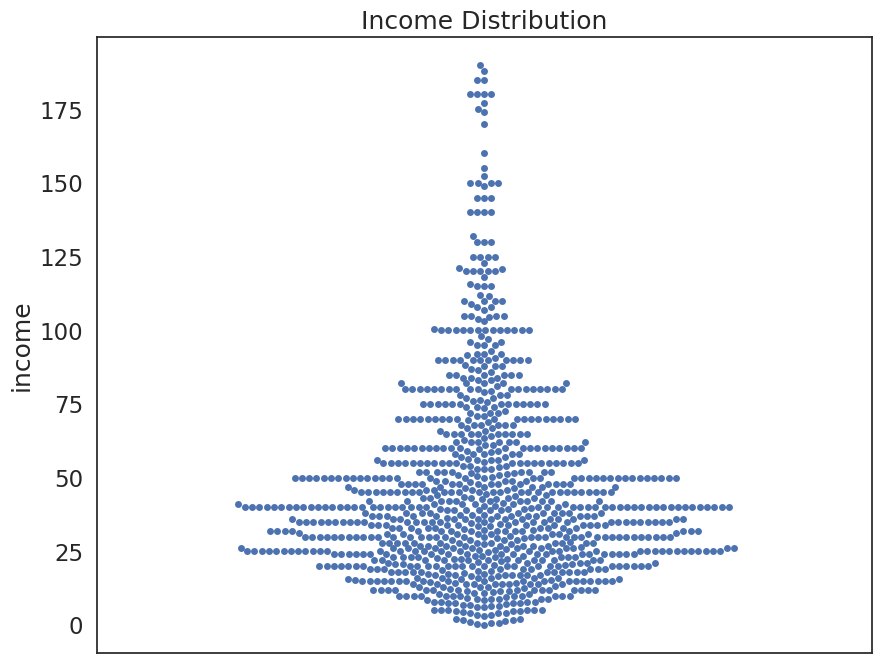

In [5]:
sample=df.sample(1000) # draw a random sample of 1000 observations from the dataframe
sns.swarmplot(data = sample, y='income') # plot a swarmplot of income
plt.title('Income Distribution') # add a title

Now let's set about calculating the 95% confidence interval and plotting it on our swarmplot. Luckily, the components we need to this are easy to calculate. We just need the mean, standard deviation, and number of observations. All of these are provided by the `.describe()` function, which calculates summary statistics for a sample.

In [6]:
desc=sample['income'].describe() # calculate descriptive statistics for the sample
print(desc) # print the descriptive statistics

count    1000.000000
mean       46.225452
std        32.922472
min         0.050000
25%        24.000000
50%        39.000000
75%        60.000000
max       190.000000
Name: income, dtype: float64


From the set of descriptive statistics, we can pull out the relevant components, calculate the standard error, and create a 95% confidence interval as follows:

In [7]:
mean=desc['mean'] # set the mean equal to a variable called "mean"
std=desc['std'] # set the standard deviation equal to a variable called "std"
n=desc['count'] # set the sample size equal to a variable called "n"
se=std/np.sqrt(n) # calculate the standard error of the mean

print('The mean is', round(mean, 2), 'with a standard error of', round(se, 2)) # print the mean and standard error

upper_ci = mean+se*1.96 # calculate the upper confidence interval
lower_ci = mean-se*1.96 # calculate the lower confidence interval

print('The 95% confidence interval is', round(lower_ci, 2), 'to', round(upper_ci, 2)) # print the confidence interval

The mean is 46.23 with a standard error of 1.04
The 95% confidence interval is 44.18 to 48.27


Finally, let's plot these bounds on our swarmplot to graphically show this range. We can now claim that based on our sample, there is a 95% chance that the true population mean of income (shown in red) lies within this range.

Text(0.5, 1.0, 'Income Distribution, 95% Confidence Interval')

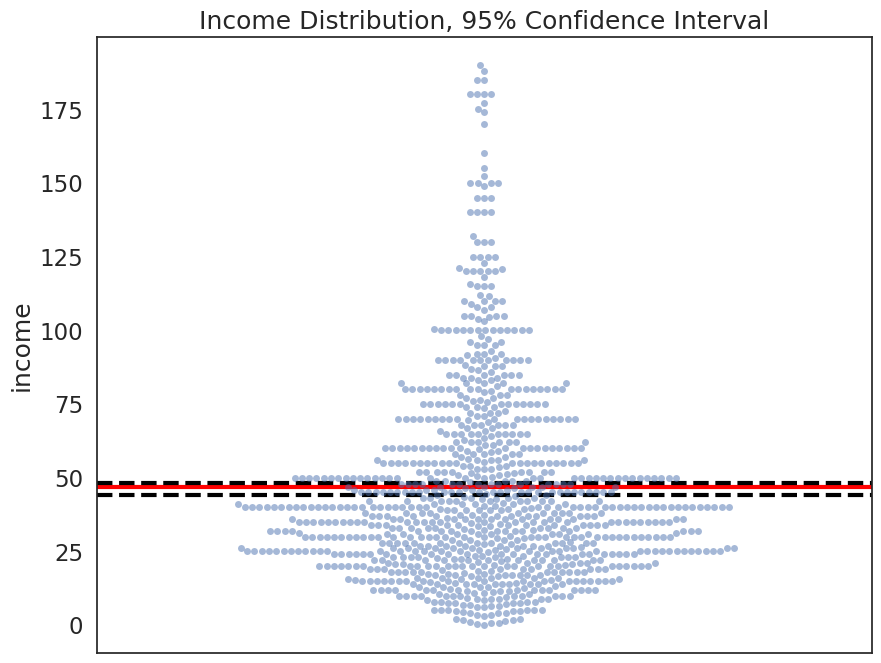

In [8]:
sns.swarmplot(data = sample, y='income',alpha=0.5) # plot a swarmplot of income
plt.axhline(df['income'].mean(), color='red', linestyle='solid', linewidth=3, label='Population Mean') # add a horizontal line at the mean
plt.axhline(upper_ci, color='black', linestyle='dashed', linewidth=3) # add a dashed black line at the upper confidence interval
plt.axhline(lower_ci, color='black', linestyle='dashed', linewidth=3) # add a dashed black line at the lower confidence interval

plt.title('Income Distribution, 95% Confidence Interval') # add a title

## Hypothesis Testing

If we create a boxplot of income disaggregated by sex using our sample, we can observe that men seem to earn more than women:

/tmp/ipython-input-3569932676.py:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.boxplot(data=sample , x='sex', y='income').set_xticklabels(['Men','Women']) # make a box plot of income by sex


[Text(0, 0, 'Men'), Text(1, 0, 'Women')]

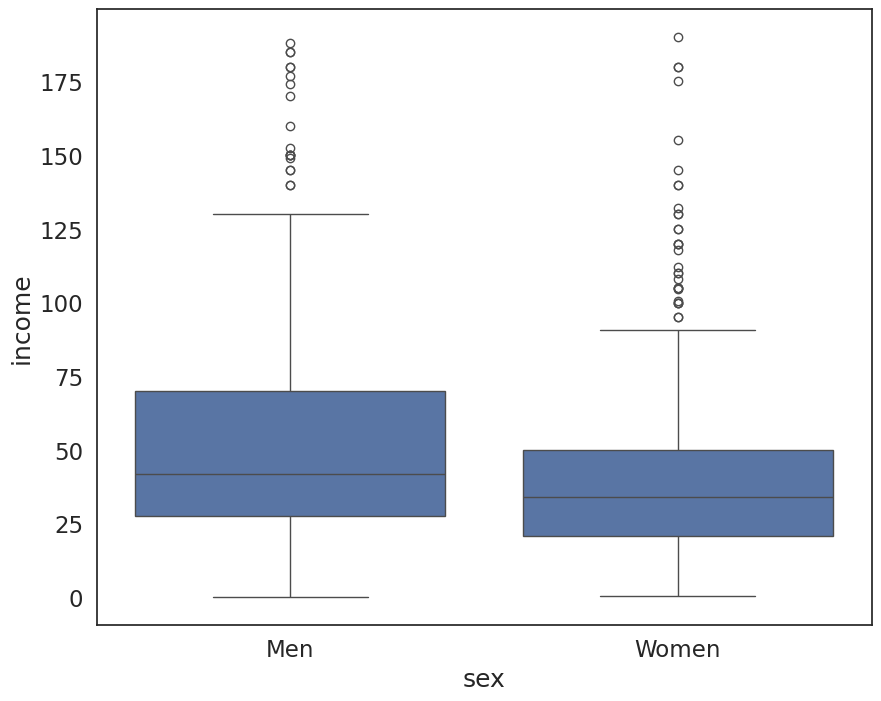

In [9]:
sns.boxplot(data=sample , x='sex', y='income').set_xticklabels(['Men','Women']) # make a box plot of income by sex

But is this difference statistically significant? It could just be due to sampling error, random chance. **Hypothesis testing** provides a framework through which we can formally evaluate the likelihood of encountering an effect as extreme (in this case, the the difference between the mean incomes between both groups) as the one we observe in our data. There are four main steps in hypothesis testing:

1. State the hypotheses. H0 states that there is no difference between the two population means.
2. Select an $\alpha$ level (e.g. 95% confidence), and select a corresponding **critical value** (1.96 for large samples)
3. Compute the test statistic.
4. Make a decision; if the test statistic exceeds the critical value, we **reject the null hypothesis**.

Steps 1, 2, and 4 remain fairly constant regardless of what kind of hypothesis testing you're conducting. Step 3 can vary quite a bit, as there are many different statistical tests that fall under the umbrella of hypothesis testing. In today's workshop we'll be using the Student's T-Test (more on that in a second). For now, let's begin the process of hypothesis testing a

### 1. State the hypotheses

#### The Null Hypothesis
* $H_0$ : There is no difference in the mean income between men and women
* $H_0$ : $\overline{x}_{men} = \overline{x}_{women}$

#### The Alternative Hypothesis
* $H_a$ : There is a difference in the mean income between men and women
* $H_a$ : $\overline{x}_{men} \neq \overline{x}_{women}$

### 2. Select an $\alpha$ level

Locate the critical region; the critical values for the t statistic are obtained using degrees of freedom ($df=n-2$). Given that we have 1000 observations, $df=998$. If $df>1000$, you can simply memorize the following critical values:

* At the 95% confidence level, the critical value is 1.96
* At the 99% confidence level, the critical value is 2.58

If our test statistic exceeds either of these values, we can reject the null hypothesis with the according level of confidence. The function below creates a plot which provides a visual reference for these values, but isn't really necessary for the process of hypothesis testing. The function accepts one argument `test_statistic`, which it will use to plot a vertical red line. If the red line falls within the dotted lines, we fail to reject the null hypothesis at the corresponding confidence level. If it's outside of these bounds, we reject the null hypothesis.

In the last line of code below, i've called the function to plot a test statistic of -2.3; Would we reject the null hypothesis at the 95% confidence level? what about the 99% level?

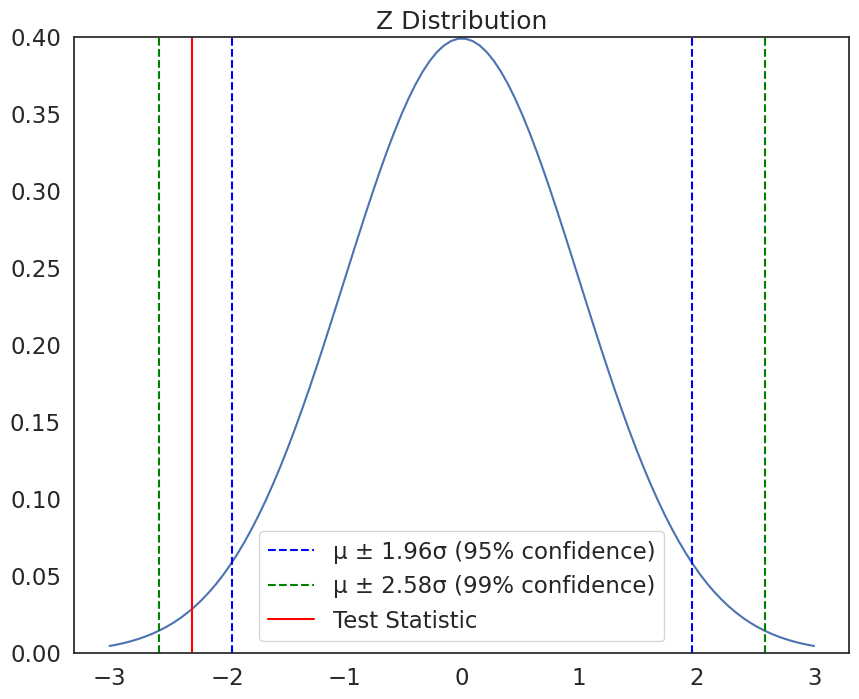

In [10]:
def plot_z(test_statistic):
    mu, se= 0, 1 # create two variables, a mean "mu" equal to zero, and standard deviation "se" equal to 1
    x = np.linspace(mu - 3*se, mu + 3*se, 100) # create a range of values from -3 to 3 standard deviations

    plt.plot(x, norm.pdf(x, mu, se)) # plot the normal distribution
    plt.axvline(mu-se*1.96, color='blue', linestyle='dashed', linewidth=1.5,label='µ ± 1.96σ (95% confidence)') # plot a vertical line at the mean plus 2 standard deviations
    plt.axvline(mu+se*1.96, color='blue', linestyle='dashed', linewidth=1.5)  # plot a vertical line at the mean minus 2 standard deviations
    plt.axvline(mu-se*2.58, color='green', linestyle='dashed', linewidth=1.5,label='µ ± 2.58σ (99% confidence)') # plot a vertical line at the mean plus 2 standard deviations
    plt.axvline(mu+se*2.58, color='green', linestyle='dashed', linewidth=1.5)  # plot a vertical line at the mean minus 2 standard deviations

    plt.axvline(test_statistic, color='red', linestyle='solid', linewidth=1.5,label='Test Statistic') # plot a vertical line at the test statistic


    plt.ylim(0,0.4)
    plt.legend()
    plt.title('Z Distribution') # add a title
    plt.show()

plot_z(-2.3)

### 3. Calculate the Test Statistic (The Student's T-Test)

The Student's T-Test is an *independent-measures design* which is used in situations where a researcher has no prior knowledge about either of the two populations (or treatments) being compared.  In particular, the population means and standard deviations are all unknown. Because the population variances are not known, these values must be estimated from the sample data.

The purpose of a T-test is to determine whether the sample mean difference indicates a real mean difference between the two populations or whether the obtained difference is simply the result of sampling error. Given two groups, $x_1$ and $x_2$, the $t$ statistic is calculated as:

$$ \Huge t = {\frac{\overline{x_1}-\overline{x_2}} {\sqrt{\frac{s^2_1}{n_1} + \frac{s^2_2}{n_2}}}} $$

Where:

* $\overline{x}$: Sample Mean
* $s^2$: Sample Standard Deviation
* $n$: Number of observations

We've already seen how to calculate each of these components when we made the 95% confidence interval above using the `.describe()` function. To calculate the t-statistic, we just have to plug these values into the formula above and do some basic arithmetic. I've put together a function that does this below, which accepts two main arguments, `group1` and `group2`. For each group it calculates descriptive statistics, and uses these values to calculate the t-statistic. It also has an optional argument `plot`, which when set to `True` will plot a 95% confidence interval for each group. It defaults to `False`, meaning that it won't generate the plot.

In [11]:
def manual_ttest(group1, group2, plot=False): # define a function called "manual_ttest" that takes two groups and a boolean value for whether or not to plot the results as arguments

    desc1, desc2=group1.describe(), group2.describe() # get descriptive statistics for both samples

    n1,std1,mean1 = desc1['count'], desc1['std'] ,desc1['mean'] # get the sample size, standard deviation, and mean of the first sample
    n2,std2,mean2 = desc2['count'], desc2['std'] ,desc2['mean'] # get the sample size, standard deviation, and mean of the second sample

    # calculate standard errors
    se1, se2 = std1**2/n1, std2**2/n2 # '**2' is the same as squaring the number

    # standard error on the difference between the samples
    sed = np.sqrt(se1 + se2)

    # calculate the t statistic
    t_stat = (mean1 - mean2) / sed

    # print the results
    print("Group 1: n=%.0f, mean=%.3f, std=%.3f" % (n1,mean1,std1))
    print("Group 2: n=%.0f, mean=%.3f, std=%.3f" % (n2,mean2,std2))
    print('The t-statistic is %.3f' % t_stat) # print the t-statistic

    if plot==True: # if the plot argument is set to True, plot the results
        groups=pd.DataFrame() # create an empty dataframe
        i=1 # create a counter variable called "i" and set it equal to 1

        for group in [group1, group2]: # loop through each group in the list of groups
            plot_df=pd.DataFrame({'Values': group,'Group':i}) # create a dataframe with the values of the group and a column called "Group" that contains the group number
            groups=groups.append(plot_df) # append the dataframe to the list of dataframes
            i+=1 # increase the counter by 1

        sns.pointplot(data=groups , x='Group', y='Values',errorbar=('ci', 95), color='black', join=False, capsize=.8) # plot the means of the groups with a 95% confidence interval
        plt.title('Comparison of Group Means with 95% Confidence Intervals') # add a title

    return t_stat # return the t-statistic

Having defined the function, we can now call it to calculate a t-test for the difference in income between men and women

In [12]:
men=sample[sample['sex']==1] # filter the sample to only include men
women=sample[sample['sex']==2] # filter the sample to only include women

t = manual_ttest(men['income'],women['income']) # run the t-test function and store the t-statistic in a variable called "t"

Group 1: n=524, mean=51.644, std=34.723
Group 2: n=476, mean=40.261, std=29.733
The t-statistic is 5.582


### 4. Make a Decision

If the t statistic indicates that the obtained difference between sample means (numerator) is substantially greater than the difference expected by chance (denominator), we reject H0 and conclude that there is a real mean difference between the two populations or treatments. Let plot the T-statistic from our test against the critical values:

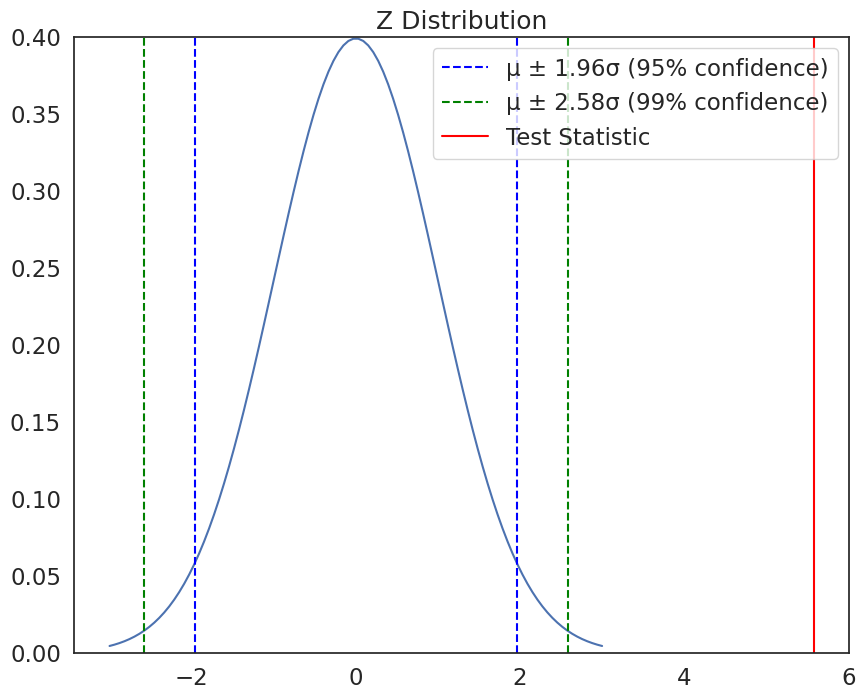

In [13]:
plot_z(t) # plot the test statistic on the z distribution

Based on the plot above, can we reject the null hypothesis that there is no difference in mean income between men and women?

### Exercise

1. From the main dataframe `df`, draw a sample of 500 white men. Using t-tests, investigate whether there are statistically significant discrepancies in pay between white men and other groups (note: it would be best to sample 500 people in each of those groups as well). Between what groups does there exist the most significant pay gap?
2. Some of this variation may be due to occupation. Compare income disparities between men and women within different occupations. Which occupation has the largest pay gap? which has the smallest?
3. [Research suggests](https://journals.sagepub.com/doi/abs/10.1177/0730888401028004005) that within occupational groups, collective bargaining through union membership reduces pay gaps. Read the abstract of this article, and try to replicate the analysis using our dataset.

In [14]:
occupations=df['occupation'].unique()
races=df['race'].unique()
for occupation in occupations:
  for race in races:
    print(race,occupation)
    men=df[(df['sex']==1)&(df['occupation']== occupation)&(df['race']==race)]
    women=df[(df['sex']==2)&(df['occupation']==occupation)&(df['race']==race)]
    t = manual_ttest(men['income'],women['income'])

1 .
Group 1: n=5081, mean=57.477, std=36.257
Group 2: n=8624, mean=38.033, std=26.661
The t-statistic is 33.291
3 .
Group 1: n=1521, mean=35.727, std=27.819
Group 2: n=2172, mean=26.493, std=20.836
The t-statistic is 10.969
2 .
Group 1: n=729, mean=40.534, std=30.416
Group 2: n=1473, mean=31.960, std=23.865
The t-statistic is 6.663
4 .
Group 1: n=791, mean=51.272, std=38.062
Group 2: n=1095, mean=38.363, std=29.861
The t-statistic is 7.937
1 Consruction, Extraction, Installation
Group 1: n=2739, mean=50.642, std=26.790
Group 2: n=91, mean=45.032, std=24.172
The t-statistic is 2.170
3 Consruction, Extraction, Installation
Group 1: n=1127, mean=35.437, std=22.528
Group 2: n=22, mean=23.759, std=13.028
The t-statistic is 4.087
2 Consruction, Extraction, Installation
Group 1: n=249, mean=41.489, std=22.758
Group 2: n=12, mean=37.568, std=21.630
The t-statistic is 0.612
4 Consruction, Extraction, Installation
Group 1: n=205, mean=50.391, std=30.457
Group 2: n=6, mean=49.167, std=38.243
The 

## Assessed question

Which occupation has the lowest income disparity between men and women? Use a For Loop and the `manual_ttest()` function, and ignore the "." category.

In [17]:
occupations=df['occupation'].unique()


for occupation in occupations:
    if occupation == '.':
        continue

    men=df[(df['sex']==1)&(df['occupation']== occupation)]
    women=df[(df['sex']==2)&(df['occupation']==occupation)]
    t = manual_ttest(men['incwage'],women['incwage'])
    print(occupation,"t=",t)



#From the output we can see the group have the lowest t value is Lawyers, Judges,Physicans and dentists t= 1.3543071794776955
#With the lowest t value 1.354





Group 1: n=4320, mean=46135.590, std=26564.959
Group 2: n=131, mean=40965.023, std=24364.365
The t-statistic is 2.386
Consruction, Extraction, Installation t= 2.386319259237804
Group 1: n=3052, mean=80191.172, std=40341.465
Group 2: n=2447, mean=63145.124, std=37461.394
The t-statistic is 16.203
Managers t= 16.203235270591264
Group 1: n=2635, mean=39788.753, std=25164.425
Group 2: n=541, mean=24597.715, std=15566.867
The t-statistic is 18.311
Transportation and materials moving t= 18.31113765925698
Group 1: n=1734, mean=43712.950, std=27564.722
Group 2: n=5486, mean=33643.429, std=18798.584
The t-statistic is 14.204
Office and Admin Support t= 14.203546826023366
Group 1: n=361, mean=43968.493, std=21425.022
Group 2: n=697, mean=40584.923, std=20485.271
The t-statistic is 2.472
Community and Social Workers t= 2.4719133164153746
Group 1: n=2449, mean=41949.286, std=22868.106
Group 2: n=1008, mean=26913.704, std=15253.129
The t-statistic is 22.556
Production t= 22.55582814725081
Group 1: 